In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanIoU
import prepareVOC12 as voc

def custom_segmentation_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    # Bridge
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up5 = UpSampling2D((2, 2))(conv4)
    concat5 = Concatenate()([up5, conv3])
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling2D((2, 2))(conv5)
    concat6 = Concatenate()([up6, conv2])
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D((2, 2))(conv6)
    concat7 = Concatenate()([up7, conv1])
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Output
    output = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model

input_shape = (224, 224, 3)
num_classes = 21

model = custom_segmentation_model(input_shape, num_classes)

In [2]:
class_dict = voc.class_dict
data_dir = "./VOC12/train"
labels_dir = "./VOC12/train_label"

x, y = voc.load_data(data_dir, labels_dir)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = x_train[:100], x_val[:20], y_train[:100], y_val[:20]

print(x_train.shape)
print(x_val.shape)    
print(y_train.shape)
print(y_val.shape)

(100, 224, 224, 3)
(20, 224, 224, 3)
(100, 224, 224, 3)
(20, 224, 224, 3)


In [3]:
# convert labels to one_hot_maps

y_train_onehot = []
y_val_onehot = []

for label_map in y_train:
    one_hot_map = voc.label_to_onehot(label_map, class_dict)
    y_train_onehot.append(one_hot_map)

for label_map in y_val:
    one_hot_map = voc.label_to_onehot(label_map, class_dict)
    y_val_onehot.append(one_hot_map)

y_train_onehot = np.array(y_train_onehot)
y_val_onehot = np.array(y_val_onehot)

In [4]:
from tensorflow.keras.optimizers import Adam

# Set your custom learning rate
learning_rate = 1e-3

# Create an Adam optimizer with the custom learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=MeanIoU(num_classes=21))

In [5]:
history = model.fit(
    x_train, y_train_onehot,
    batch_size=5,
    epochs=10,
    validation_data=(x_val, y_val_onehot),
    verbose=1
)

Epoch 1/10
20/20 [==============================] - 15s 350ms/step - loss: 0.2261 - mean_io_u: 0.4777 - val_loss: 0.1106 - val_mean_io_u: 0.4775
Epoch 2/10
20/20 [==============================] - 7s 328ms/step - loss: 0.0964 - mean_io_u: 0.4777 - val_loss: 0.1019 - val_mean_io_u: 0.4775
Epoch 3/10
20/20 [==============================] - 6s 325ms/step - loss: 0.0929 - mean_io_u: 0.4777 - val_loss: 0.1021 - val_mean_io_u: 0.4775
Epoch 4/10
20/20 [==============================] - 6s 324ms/step - loss: 0.0921 - mean_io_u: 0.4777 - val_loss: 0.1117 - val_mean_io_u: 0.4775
Epoch 5/10
20/20 [==============================] - 7s 326ms/step - loss: 0.0952 - mean_io_u: 0.4777 - val_loss: 0.1039 - val_mean_io_u: 0.4775
Epoch 6/10
20/20 [==============================] - 6s 325ms/step - loss: 0.0923 - mean_io_u: 0.4777 - val_loss: 0.1013 - val_mean_io_u: 0.4775
Epoch 7/10
20/20 [==============================] - 7s 328ms/step - loss: 0.0922 - mean_io_u: 0.4777 - val_loss: 0.1003 - val_mean_io_u

In [6]:
with tf.device('/CPU:0'):
    predictions = model.predict(x_train, batch_size=5)

20/20 [==============================] - 21s 1s/step


In [7]:
y_pred = []
for onehot in predictions:
    y_pred.append(voc.onehot_to_label(onehot, voc.class_dict))

y_pred = np.array(y_pred).astype('uint8')

Text(0.5, 1.0, 'Converted prediction')

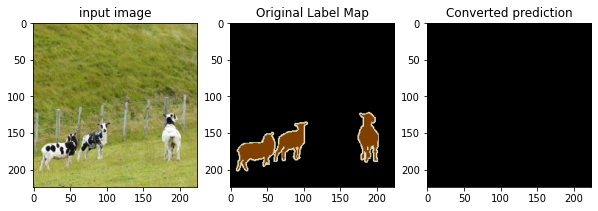

In [8]:
index = 7
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(x_train[index])
axs[0].set_title('input image')
axs[1].imshow(y_train[index])
axs[1].set_title('Original Label Map')
axs[2].imshow(y_pred[index])
axs[2].set_title('Converted prediction')